# Training and Validation 
In this notebook, we will train and validate the model of choice.

In [1]:
### Michael Engel ### 2022-04-25 ### main.ipynb ###
### adapted by Niklas Eisl, Colin Moldenhauer, 2022/23 ###
%matplotlib inline
import os
import sys
import platform
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time
import natsort

import torch
from tensorboardX import SummaryWriter

from eolearn.core import FeatureType

from libs.ConfigME import Config, importME, get_most_recent_config
from libs.QuantileScaler_eolearn import QuantileScaler_eolearn_tdigest
from libs.Dataset_eolearn import Dataset_eolearn
from libs import AugmentME

print("Working Directory:",os.getcwd())
print("Environment:",os.environ['CONDA_DEFAULT_ENV'])
print("Executable:",sys.executable)

Working Directory: /home/ldbv/treecurrent
Environment: treecurrent2
Executable: /home/ldbv/anaconda3/envs/treecurrent2/bin/python


# Config
First, we load our configuration file which provides all information we need throughout the script.

In [2]:
config_name = get_most_recent_config(".", pattern="config_.*[.]dill", mode="m")
config = Config.LOAD(config_name)
print("loaded config:", config_name)

loaded config: config_Treecurrent_2023-01-26-17-34-04-553268.dill


# Batch Size
As we deal with high dimensional data and several time stamps, it is important to choose a reasonably low batch size. A too small batch size on the other hand will result in highly stochastic gradients. We have found a batch size of 6 to work well for this task.

In [3]:
bs = config['batch_size']
print(f'Chosen batch_size: {bs}')

Chosen batch_size: 6


# Quantile Scaling
As discussed in the second notebook, we want to apply quantile scaling to our data.
We load the scaler that we have already defined.

In [4]:
Scaler = QuantileScaler_eolearn_tdigest.LOAD(os.path.join(config["dir_results"],config["savename_scaler"]))

# Dataloader
First, we need to get the paths for all samples within our training and validation datasets, respectively. More specifically, we create a list of paths that will then be passed to the `Dataset_eolearn` class which prepares the data in a way such that the dataloader can load it into the batches that we use during training and validation.

In [5]:
paths_train = [os.path.join(config["dir_train"], file).replace("\\","/") for file in os.listdir(config["dir_train"])]

In [6]:
paths_validation = [os.path.join(config["dir_val"], file).replace("\\","/") for file in os.listdir(config["dir_val"])]

Now, we are ready to define our datasets using the `Dataset_eolearn` class!

Remember that PyTorch asks for the shape `[batch_size x channels x timestamps x height x width]`.
The `Quantile
_eolearn_tdigest` handles this by setting `transform=Torchify(1)`.
For the reference and the mask, we use the `Torchify` class as provided from the `Dataset_eolearn` package, too.

So befor we initialize the Datasets, let's briefly have a look at the `Torchify` class. In a nutshell, this class handles our final transforms such that Pytorch can use the data for training. This includes rearranging of dimensions and removing of `NaN` values.

In [ ]:
def torchify(array):
    return np.moveaxis(array, -1, 0)

def nan_to_value(array, value=0):
    nan_loc = np.isnan(array)
    array[nan_loc] = value
    return array


class Torchify():
    def __init__(self,squeeze=False, nanvalue=0):
        self.squeeze = squeeze
        self.nanvalue = nanvalue
    def __call__(self,array):
        array_ = torchify(array)
        array_ = nan_to_value(array_, value=self.nanvalue)

        if self.squeeze==True:
            return array_.squeeze()
        elif type(self.squeeze)==int:
            return array_.squeeze(self.squeeze)
        else:
            return array_

In [8]:
dataset_train = Dataset_eolearn(
    paths = paths_train,
    feature_data = (FeatureType.DATA, "data"),
    feature_reference = (FeatureType.DATA, "reference"),
    feature_mask = (FeatureType.MASK, "mask_reference"),

    transform_data = Scaler,
    transform_reference = Torchify(squeeze=1, nanvalue=0),
    transform_mask = Torchify(squeeze=1, nanvalue=0),
    
    return_idx = False,
    return_path = False,

    torchdevice = None,
    torchtype_data = torch.FloatTensor,
    torchtype_reference = torch.FloatTensor,
    torchtype_mask = torch.FloatTensor,
)

In [9]:
dataset_validation = Dataset_eolearn(
    paths = paths_validation,
    feature_data = (FeatureType.DATA, "data"),
    feature_reference = (FeatureType.DATA, "reference"),
    feature_mask = (FeatureType.MASK,"mask_reference"),

    transform_data = Scaler,
    transform_reference = Torchify(squeeze=1, nanvalue=0),
    transform_mask = Torchify(squeeze=1, nanvalue=0),
    
    return_idx = False,
    return_path = False,

    torchdevice = None,
    torchtype_data = torch.FloatTensor,
    torchtype_reference = torch.FloatTensor,
    torchtype_mask = torch.FloatTensor,
)

Let's test our datasets! 

As we can see, each batch of our input data `x` consists of 
- 6 samples, 
- 6 channels (where the channels correpond to the downloaded bands `B02`, `B03`, `B04`, `B08`, `B8A` and `B11`),
- 8 consecutive time stamps
- and a spatial resolution of `256x256` for each patch.

The corresponding reference `y` collapses the channel and timestamp dimesions and we end up with
- 6 samples
- and a spatial resolution of `256x256` for each patch, where all values are in the range `[-1,1]` to represent the NDVI index.

The mask has the same shape as the reference `y` with binary values to filter with the`no-data mask` and `cloud mask`.

In [10]:
sample_train = dataset_train[:config["batch_size"]]
print('Training Data Shape:',sample_train[0].shape)
print('Training Reference Shape:',sample_train[1].shape)
print('Training Mask Shape:',sample_train[2].shape)
print()

sample_validation = dataset_validation[:config["batch_size"]]
print('Validation Data Shape:',sample_validation[0].shape)
print('Validation Reference Shape:',sample_validation[1].shape)
print('Validation Mask Shape:',sample_validation[2].shape)

Training Data Shape: torch.Size([6, 6, 8, 256, 256])
Training Reference Shape: torch.Size([6, 256, 256])
Training Mask Shape: torch.Size([6, 256, 256])

Validation Data Shape: torch.Size([6, 6, 8, 256, 256])
Validation Reference Shape: torch.Size([6, 256, 256])
Validation Mask Shape: torch.Size([6, 256, 256])



Let's define our dataloader for each dataset.
We will double our `batch_size` for validation as no gradient calculation is needed here.

In [11]:
dataloader_train = torch.utils.data.DataLoader(
    dataset = dataset_train,
    batch_size = config["batch_size"],
    shuffle = True,
    sampler = None,
    batch_sampler = None,
    num_workers = 0 if platform.system()=="Windows" else config["threads"],
    collate_fn = None,
    pin_memory = False,
    drop_last = True,
    timeout = 0,
    worker_init_fn = None,
    multiprocessing_context = None
)

In [12]:
dataloader_validation = torch.utils.data.DataLoader(
    dataset = dataset_validation,
    batch_size = config["batch_size"]*2,
    shuffle = False,
    sampler = None,
    batch_sampler = None,
    num_workers = 0 if platform.system()=="Windows" else config["threads"],
    collate_fn = None,
    pin_memory = False,
    drop_last = True,
    timeout = 0,
    worker_init_fn = None,
    multiprocessing_context = None
)

# Model
Now, it's time to initialise our model.
We will do that using `importME` since we want to keep flexibility with regard to the model architecture used. That way, changes can easily be made in the Configuaration Notebook without having to modify this Notebook.

In [13]:
module_model = importME(config["module_model"])

Since we are dealing with time-series data in image format, we have chosen a `Convolutional LSTM` architecture as our model. 

The original paper can be found [here](https://arxiv.org/abs/1506.04214). 
The model used in this notebook slightly deviates from the paper and the implementation can be found [here](https://github.com/ndrplz/ConvLSTM_pytorch).

The dynamics implemented in the used model can be described as:

[<img src="https://user-images.githubusercontent.com/7113894/59357391-15c73e00-8d2b-11e9-8234-9d51a90be5dc.png">](https://user-images.githubusercontent.com/)

When executing the following cell, one can see the small overall model that is currently used alongside with the hpyerparameters that are defined in the config file.

In [14]:
model = module_model(**config["kwargs_model"])
model

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(26, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(21, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

Now, we want to augment the model such that it fits in our training pipeline.
We will add some IO methods such as saving and loading to it.
Further, we will add a method for getting the gradients during training.
That will be used for a brainwave monitor.
The benefit of that gets clear if you think of changing the architecture used but do not mean to change the IO interface of your code.

In [15]:
AugmentME.augment_IO(model,savekey='save',loadkey='load',mode='torch')

True

In [16]:
AugmentME.augment_checkpoint(model,key='save_checkpoint',mode='torch')

True

In [17]:
AugmentME.augment_gradient(model,key='get_gradient',mode=None)

In [18]:
AugmentME.augment_Ntheta(model,key="get_Ntheta")

True

As a test if the augmenting worked, we want to have a look at the number of parameters.

In [19]:
print("Number of parameters:",model.get_Ntheta())

Number of parameters: 48440


# Training
Before we can start training our model, we have to define a loss function.
We will keep it as flexible as the model itself and use `importME`. 

As we deal with a regression task we use a classical `MSE Loss` function. However, it is important to also take the mask into account that we get for each batch in addition to `x` and `y`. The loss fuction can be modified such that no loss is computed for those pixels where the mask has a value of 1. 

We have implemented such a custom loss called `MSELossMasked` which can be found in `libs\loss.py`.

In [20]:
loss_function = importME(config["module_loss"])(**config["kwargs_loss"])

No optimization without an optimizer! 
Due to corresponding device issues, we have to send our model to the device before we define our optimizer.

In [21]:
model.to(config["device"])

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(26, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(21, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

Now, we can define our optimizer with the parameters already been sent to our chosen device!

In [22]:
optimizer = importME(config["module_optimizer"])(model.parameters(),**config["kwargs_optimizer"])
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 7e-05
    maximize: False
    weight_decay: 1e-06
)

## Sanity Check

When training a NN is makes sense to perform simple debugging steps before running the model for hours!
A very simple idea to do so is to overfit a small subset of our data.
**Overfitting a single sample** verifies that the loss function works properly and **overfitting on a single batch** helps us to catch a large number of bugs early!

In our case, we optimize the model on one single batch for 100 iterations and see that our loss goes towards 0!

Overfitting to a single batch for 100 steps...
Iteration: 10, Loss: 0.2248678207397461
Iteration: 20, Loss: 0.21632389724254608
Iteration: 30, Loss: 0.20345477759838104
Iteration: 40, Loss: 0.1812230348587036
Iteration: 50, Loss: 0.1417338252067566
Iteration: 60, Loss: 0.08976586163043976
Iteration: 70, Loss: 0.07031788676977158
Iteration: 80, Loss: 0.07202398031949997
Iteration: 90, Loss: 0.06893713772296906
Iteration: 100, Loss: 0.06867506355047226


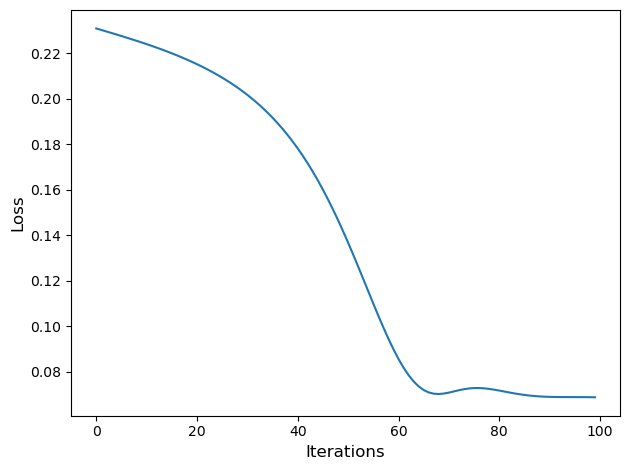

In [23]:
# get a batch from the dataloader
x, y, mask = next(iter(dataloader_train))
# send it to correct device
x = x.to(config["device"])
y = y.to(config["device"])
mask = mask.to(config["device"])
# append losses for visualization
loss_history = []
print('Overfitting to a single batch for 100 steps...')
for i in range(100):
    out, _ = model.forward(x)
    pred = out[0][:, -1, ...].squeeze().to(config["device"])
    optimizer.zero_grad()
    loss = loss_function(pred, y, mask)
    loss_history.append(loss.item())
    loss.backward()
    optimizer.step()
    if (i+1)%10 == 0:
        print(f'Iteration: {i+1}, Loss: {loss}')
# plot the loss function
plt.plot(loss_history)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.tight_layout()


To assess the performance of our model, we load some metrics. Similar to the loss function, we use the `Masked MSE Loss` function as our first metric and a `Squared Variance Error` to also take the variance into account. The implementatin of both metrics can be found in `libs\metrics.py`

In [26]:
metric = importME(config["module_metric"])

Of course, we would like to track the proceeding of our training procedure.
Hence, we define a tensorboard [SummaryWriter](https://tensorboardx.readthedocs.io/en/latest/tensorboard.html#tensorboardX.SummaryWriter).

In [27]:
writer = SummaryWriter(config["dir_tensorboard"])

Anyway, we would like to make our experiment reproducible.
Thus, we set the seeds such that all random number generation and shuffling is done in a deterministic manner.

In [28]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In case of a premature exit of the training procedure, we insert a resume flag here.
It enables the user to start with the chosen checkpoint or automatically choose the most recent one.

In [29]:
resume = False

In [30]:
if resume:
    if resume==True:
        resume = os.path.join(config["dir_checkpoints"],natsort.natsorted(os.listdir(config["dir_checkpoints"]))[-1])
    else:
        resume = resume
    
    print(f'Loading Checkpoint {resume}!')
    checkpoint = torch.load(resume,map_location=config["device"])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    bestloss = checkpoint['bestloss']
    epoch_ = checkpoint['epoch']+1
    logstep_ = checkpoint['logstep']
else:
    epoch_ = 0
    logstep_ = 0
    bestloss = np.inf

model.train()

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(26, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(21, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

Let's start the training loop!

In [31]:
print('Start training...')
tic = time.time()
device = config["device"]
logstep = -1+logstep_
for epoch in range(config["n_epochs"]-epoch_):
    epoch = epoch+epoch_
    for step, (x, y, mask) in enumerate(dataloader_train):

        x = x.to(device)
        y = y.to(device)
        mask = mask.to(device)
        
        #%%% clean cache of GPU
        torch.cuda.empty_cache()

        #%%% compute logstep
        logstep = logstep+1

        #%%% zero gradients
        optimizer.zero_grad(set_to_none=True)

        # get prediction
        out, _ = model(x)
        pred = out[0][:, -1, ...].squeeze()

        #%%% compute and rescale loss
        loss = loss_function(pred, y, mask)

        #%%% compute metric
        if type(metric)==list:
            train_acc = [metric_(pred, y, mask).cpu().detach() for metric_ in metric]
        else:
            train_acc = metric(pred, y, mask).cpu().detach()
        

        #%%% compute gradient
        loss.backward()

        #%%% update model parameters
        optimizer.step()

        #%%% printing stuff
        print(
            "[{}] Training Step: {:d}/{:d} {:d}.{:d}, \tbatch_size: {} \tLoss: {:.4f}".format(
                dt.datetime.now().strftime("%Y-%m-%dT%H-%M-%S"),
                logstep+1,
                len(dataloader_train)*config["n_epochs"],
                epoch,
                step,
                config["batch_size"],
                loss.mean(),
            )
        )

        #%%% write to tensorboard
        #%%%% log loss
        writer.add_scalar(f'LossTraining/{type(loss_function).__name__}', loss, global_step=logstep)
        
        #%%%% log metric
        if type(metric)==list:
            writer.add_scalars('AccuracyTraining',{metric_.__name__:train_acc_ for metric_,train_acc_ in zip(metric,train_acc)},global_step=logstep)
        else:
            writer.add_scalar('AccuracyTraining', train_acc, global_step=logstep)
        
        #%%%% gradients
        writer.add_histogram('GradientsTraining/AllParams', model.get_gradient(mode='vec',index=None), global_step=logstep, bins=50, walltime=None, max_bins=100)
        for name,grad in model.get_gradient(mode='named params',device="cpu",detach=True):
            writer.add_histogram(f'NamedGradientsTraining/{name}', grad, global_step=logstep, bins=50, walltime=None, max_bins=100)
        
    #%%% intermediate evaluation of validation set
    if config["eval_freq"] and (epoch+1)%config["eval_freq"]==0:
        print()
        model.eval()
        loss_val = []
        acc_val = []
        weights_val = []
        
        n_plot_validation = 8
        
        with torch.no_grad():
            fig, axis = plt.subplots(nrows=n_plot_validation*2, ncols=dataloader_validation.batch_size,
                                     figsize=(3*dataloader_validation.batch_size,2*3*n_plot_validation))
            fig.suptitle('Validation Data %i'%logstep)
            for step_validation, (x_validation, y_validation, mask_validation) in enumerate(dataloader_validation):
                
                x_validation = x_validation.to(device)
                y_validation = y_validation.to(device)
                mask_validation = mask_validation.to(device)
                    

                #%%%% clean cache of GPU
                torch.cuda.empty_cache()

                out_validation, _ = model.forward(x_validation)
                pred_validation = out_validation[0][:, -1, ...].squeeze()


                #%%% compute loss
                loss_validation = loss_function(pred_validation, y_validation, mask_validation)
                
                #%%%% compute metric
                if type(metric)==list:
                    validation_acc = [metric_(pred_validation, y_validation, mask_validation).cpu().detach() for metric_ in metric]
                else:
                    validation_acc = metric(pred_validation, y_validation, mask_validation).cpu().detach()
                #%%%% printing stuff
                print(
                    "[{}] Validation Step: {:d}/{:d}, \tbatch_size: {} \tLoss: {:.4f}".format(
                        dt.datetime.now().strftime("%Y-%m-%dT%H-%M-%S"),
                        step_validation+1,
                        len(dataloader_validation),
                        dataloader_validation.batch_size,
                        loss_validation.mean(),
                    )
                )
                
                #%%%% visualize the predictions from the validation set and compare it to the reference for several
                #%%%% timestamps to visually see how the predictions get closer to the reference over time
                if step_validation < n_plot_validation:
                    axis[step_validation*2][0].set_ylabel("Prediction")
                    axis[step_validation*2+1][0].set_ylabel("Reference")
                    for i in range(dataloader_validation.batch_size):
                        
                        axis[step_validation*2][i].imshow(pred_validation[i].squeeze().cpu().detach(),
                                                          vmin=-1,vmax=1,cmap="Greens")
                        axis[step_validation*2][i].set_xticks([])
                        axis[step_validation*2][i].set_yticks([])

                        axis[step_validation*2+1][i].imshow(y_validation[i].squeeze().cpu().detach().numpy(),
                                                            vmin=-1,vmax=1,cmap="Greens")
                        axis[step_validation*2+1][i].set_xticks([])
                        axis[step_validation*2+1][i].set_yticks([])
                    
                #%%%% collect loss and accuracy
                loss_val.append(loss_validation.cpu().detach().numpy())
                acc_val.append(validation_acc)
                weights_val.append(torch.count_nonzero(mask_validation).cpu().detach().numpy())

            #%%%% total loss and accuracy
            total = np.sum([np.sum(weight_) for weight_ in weights_val])
            loss_val_total = np.sum([weight_/total*loss_ for weight_,loss_ in zip(weights_val,loss_val)])
            if type(metric)==list:
                acc_val_total = [np.sum([weight_/total*acc_[i] for weight_,acc_ in zip(weights_val,acc_val)]) for i in range(len(metric))]
            else:
                acc_val_total = np.sum([weight_/total*acc_ for weight_,acc_ in zip(weights_val,acc_val)])
            
            # print total values
            print(
                "[{}] Validation: \tTotal Loss: {:.4f}".format(
                    dt.datetime.now().strftime("%Y-%m-%dT%H-%M-%S"),
                    loss_val_total,
                    {metric_.__name__:validation_acc_ for metric_,validation_acc_ in zip(metric,acc_val_total)} if type(metric)==list else acc_val_total
                )
            )

            #%%%% write to tensorboard
            #%%%%% log loss
            writer.add_scalar(f'LossValidation/{type(loss_function).__name__}', loss_val_total, global_step=logstep)

            #%%%%% log metric
            if type(metric)==list:
                writer.add_scalars('AccuracyValidation',{metric_.__name__:validation_acc_ for metric_,validation_acc_ in zip(metric,acc_val_total)},global_step=logstep)
            else:
                writer.add_scalar('AccuracyValidation', acc_val_total, global_step=logstep)
            
            #%%%%% log figure
            plt.tight_layout()
            plt.savefig(fname=os.path.join(config["dir_imgs_validation"],"PredictionValidation_%i"%logstep), dpi="figure")
            writer.add_figure(tag="PredictionValidation", figure=fig, global_step=logstep, close=True, walltime=None)

        model.train()
        print()
        #%%% checkpoint for best validation loss
        if config["checkpoint_bestloss"] and bestloss>loss_val_total:
            print("New best validation loss! Storing checkpoint and model!")
            model.save_checkpoint(
                savename = os.path.join(config["dir_checkpoints"],'checkpoint_bestloss.tar'),
                epoch = epoch,
                logstep = logstep,
                optimizer_state_dict = optimizer.state_dict(),
                loss = loss,
                bestloss = loss_val_total
            )
            model.save(savename=os.path.join(config["dir_results"],config["model_savename_inference_bestloss"]),mode='inference')
            model.save(savename=os.path.join(config["dir_results"],config["model_savename_bestloss"]),mode='entirely')
            bestloss = loss_val_total

    #%%% checkpoint
    if config["checkpoint_freq"] and (epoch+1)%config["checkpoint_freq"]==0:
        model.save_checkpoint(
            savename = os.path.join(config["dir_checkpoints"],f'checkpoint_{logstep}_{epoch}_{step}.tar'),
            epoch = epoch,
            logstep = logstep,
            optimizer_state_dict = optimizer.state_dict(),
            loss = loss,
            bestloss = loss_val_total
        )
        
print(f"Training took {time.time() - tic} s for {config['n_epochs']-epoch_} epochs")


Start training...
[2023-01-26T17-39-16] Training Step: 1/2370 0.0, 	batch_size: 6 	Loss: 0.1289
[2023-01-26T17-39-16] Training Step: 2/2370 0.1, 	batch_size: 6 	Loss: 0.2031
[2023-01-26T17-39-16] Training Step: 3/2370 0.2, 	batch_size: 6 	Loss: 0.2088
[2023-01-26T17-39-17] Training Step: 4/2370 0.3, 	batch_size: 6 	Loss: 0.3447
[2023-01-26T17-39-17] Training Step: 5/2370 0.4, 	batch_size: 6 	Loss: 0.2457
[2023-01-26T17-39-18] Training Step: 6/2370 0.5, 	batch_size: 6 	Loss: 0.3078
[2023-01-26T17-39-19] Training Step: 7/2370 0.6, 	batch_size: 6 	Loss: 0.3059
[2023-01-26T17-39-19] Training Step: 8/2370 0.7, 	batch_size: 6 	Loss: 0.3067
[2023-01-26T17-39-20] Training Step: 9/2370 0.8, 	batch_size: 6 	Loss: 0.3130
[2023-01-26T17-39-20] Training Step: 10/2370 0.9, 	batch_size: 6 	Loss: 0.3389
[2023-01-26T17-39-21] Training Step: 11/2370 0.10, 	batch_size: 6 	Loss: 0.3953
[2023-01-26T17-39-21] Training Step: 12/2370 0.11, 	batch_size: 6 	Loss: 0.2961
[2023-01-26T17-39-21] Training Step: 13/2

KeyboardInterrupt: 

In [ ]:
print('saving final checkpoint!')
model.save_checkpoint(savename=os.path.join(config["dir_checkpoints"],f'checkpoint_{logstep}_{epoch}_{step}.tar'), epoch=epoch, logstep=logstep, optimizer_state_dict=optimizer.state_dict(), loss=loss)
print('saving inference model')
model.save(savename=os.path.join(config["dir_results"],config["model_savename_inference"]),mode='inference')
print('saving entire model')
model.save(savename=os.path.join(config["dir_results"],config["model_savename"]),mode='entirely')